In [4]:
pip install qiskit


In [5]:
pip install pylatexenc
# remove when in qiskitschool env

     |████████████████████████████████| 163kB 2.8MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.7-cp36-none-any.whl size=130764 sha256=6b5091be51d3180f1554b0518238c8e8a609ab0039948c247fd578746735259a
  Stored in directory: /root/.cache/pip/wheels/d3/e6/ca/261bd01506ba7e835ed21bfec202389cf670198b87cde58a84
Successfully built pylatexenc


In [21]:
from qiskit import *
import matplotlib
import numpy as np

from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_qsphere


In [28]:
# Initialize gate parameters at 0 and draw quantum circuit for gradient descent

theta_x_0 = 0
theta_x_1 = 0
theta_y_0 = 0
theta_y_1 = 0

circ = QuantumCircuit(2,2)

circ.ry(theta_y_0,0)
circ.rx(theta_x_1, 1)
circ.cx(0,1)
circ.rx(theta_x_0, 0)
circ.ry(theta_y_1, 1)
#circ.measure([0,1],[0,1])

%matplotlib inline
circ.draw()

┌───────┐     ┌───────┐
q_0: ┤ RY(0) ├──■──┤ RX(0) ├
     ├───────┤┌─┴─┐├───────┤
q_1: ┤ RX(0) ├┤ X ├┤ RY(0) ├
     └───────┘└───┘└───────┘
c: 2/═══════════════════════

Gradident Descent Statevector:  [1.+0.j 0.+0.j 0.+0.j 0.+0.j] 



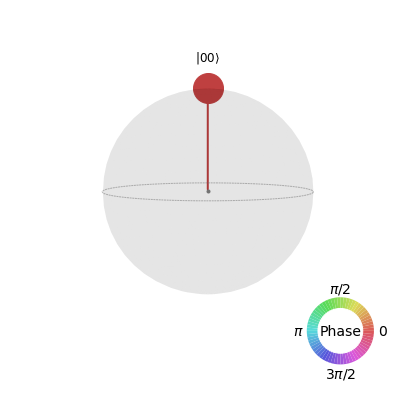

In [30]:
backend = Aer.get_backend('statevector_simulator')
result = execute(circ,backend).result().get_statevector()
print("Initial Statevector: ", result, "\n")

state = Statevector.from_instruction(circ)
plot_state_qsphere(state)

In [11]:
#REMOVE BEFORE SUBMIT
theta_x_0 = 1.5
circ.draw()
#Moral: redraw entire circuit after gradient descent, including gate redefinition

┌───────┐     ┌───────┐┌─┐   
q_0: ┤ RY(0) ├──■──┤ RX(0) ├┤M├───
     ├───────┤┌─┴─┐├───────┤└╥┘┌─┐
q_1: ┤ RX(0) ├┤ X ├┤ RY(0) ├─╫─┤M├
     └───────┘└───┘└───────┘ ║ └╥┘
c: 2/════════════════════════╩══╩═
                             0  1

In [22]:
# Compare optimization statevector to GHZ circuit, drawn here

circ_ghz = QuantumCircuit(2,2)
circ_ghz.x(1)
circ_ghz.barrier()
circ_ghz.h(0)
circ_ghz.barrier()
circ_ghz.cx(0,1)
circ_ghz.barrier()
#circ_ghz.measure([0,1],[0,1])

circ_ghz.draw()

░ ┌───┐ ░       ░ 
q_0: ──────░─┤ H ├─░───■───░─
     ┌───┐ ░ └───┘ ░ ┌─┴─┐ ░ 
q_1: ┤ X ├─░───────░─┤ X ├─░─
     └───┘ ░       ░ └───┘ ░ 
c: 2/════════════════════════

GHZ Statevector:  [0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j] 



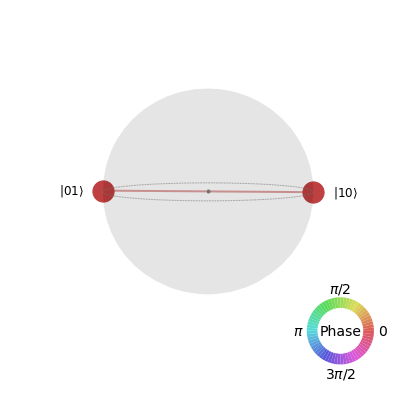

In [27]:
# Statevector output of GHZ

backend = Aer.get_backend('statevector_simulator')
result = execute(circ_ghz,backend).result().get_statevector()
print("GHZ Statevector: ", result, "\n")

state = Statevector.from_instruction(circ_ghz)
plot_state_qsphere(state)